<a href="https://colab.research.google.com/github/swardiantara/fp-dm-2021/blob/main/GRU%2BFasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
data_traindf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATMIN/FP/train.csv')
data_testdf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATMIN/FP/test.csv')
data_merged = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATMIN/FP/merged.csv')

In [4]:
data_traindf.head()

sentence #     word    pos tag  word_idx  tag_idx
0           1  Berikut  PROPN   O       805        4
1           1   adalah    AUX   O      5456        4
2           1    tujuh    NUM   O      3291        4
3           1     kota   NOUN   O      7522        4
4           1       di    ADP   O      2096        4

In [5]:
data_testdf.head()

sentence #           word    pos    tag  word_idx  tag_idx
0           1       Presiden  PROPN      O        79        4
1           1       terpilih   VERB      O      7980        4
2           1           Joko  PROPN  B-PER      2526        2
3           1         Widodo  PROPN  I-PER      7595        5
4           1  mengungkapkan   VERB      O      3199        4

In [6]:
data_merged.head()

sentence #     word    pos tag  word_idx  tag_idx
0           1  Berikut  PROPN   O       805        4
1           1   adalah    AUX   O      5456        4
2           1    tujuh    NUM   O      3291        4
3           1     kota   NOUN   O      7522        4
4           1       di    ADP   O      2096        4

In [7]:
print("Train Shape : ", data_traindf.shape)
print("Test Shape : ", data_testdf.shape)
print("Merged Shape : ", data_merged.shape)

Train Shape :  (30248, 6)
Test Shape :  (18451, 6)
Merged Shape :  (48699, 6)


In [8]:
data_traindf["tag"].value_counts()

O        26728
B-PER      896
B-ORG      721
B-LOC      579
I-ORG      577
I-PER      486
I-LOC      261
Name: tag, dtype: int64

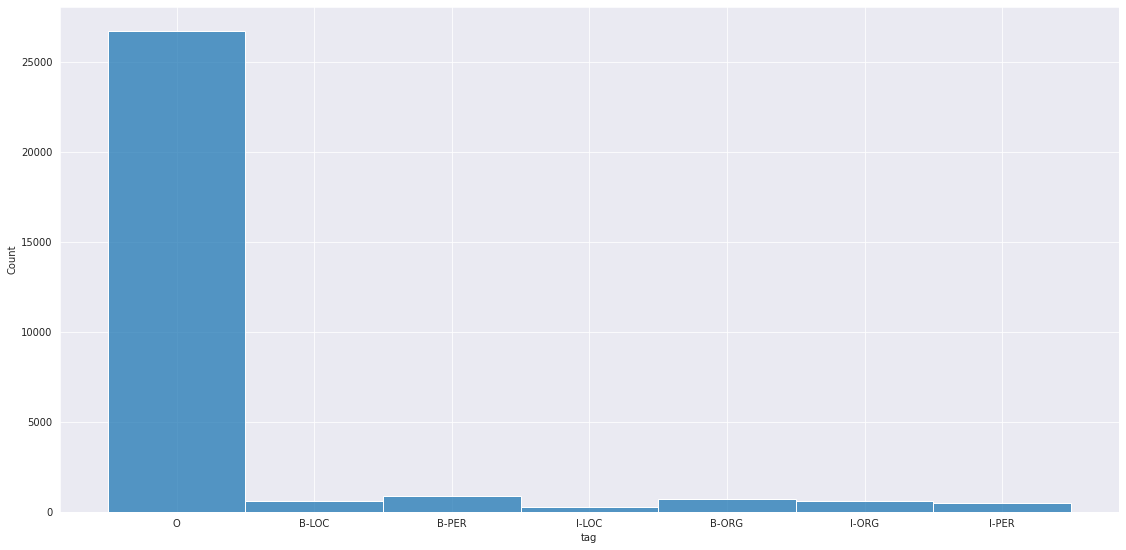

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(data_traindf['tag'])
plt.tight_layout(pad=2)
plt.show()

In [10]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['word'].to_list()))
    else:
        vocab = list(set(data['tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok, vocab

In [11]:
token2idx, idx2token, word_vocab = get_dict_map(data_merged, 'token')
tag2idx, idx2tag, tag_vocab = get_dict_map(data_merged, 'tag')
word_vocab.append("ENDPAD")

In [12]:
data_traindf_fillna = data_traindf.fillna(method='ffill', axis=0)
data_testdf_fillna = data_testdf.fillna(method='ffill', axis=0)
data_merged_fillna = data_merged.fillna(method='ffill', axis=0)

In [13]:
data_traindf_group = data_traindf_fillna.groupby(["sentence #"], as_index=False)['word','tag','word_idx','tag_idx'].agg(lambda x:list(x))
data_testdf_group = data_testdf_fillna.groupby(["sentence #"], as_index=False)['word','tag','word_idx','tag_idx'].agg(lambda x:list(x))
data_merged_group = data_merged_fillna.groupby(["sentence #"], as_index=False)['word','tag','word_idx','tag_idx'].agg(lambda x:list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
data_traindf_group.head()

sentence #  ...                                            tag_idx
0           1  ...            [4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4]
1           2  ...  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, ...
2           3  ...  [4, 4, 4, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, ...
3           4  ...                  [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
4           5  ...  [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...

[5 rows x 5 columns]

In [15]:
maxlen_merged = max([len(s) for s in data_merged_group['word_idx'].tolist()])
maxlen_train = max([len(s) for s in data_traindf_group['word_idx'].tolist()])
maxlen_test = max([len(s) for s in data_testdf_group['word_idx'].tolist()])

In [16]:
print("Merged :", maxlen_merged)
print("Train :", maxlen_train)
print("Test :", maxlen_test)

Merged : 112
Train : 69
Test : 94


In [17]:
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def get_pad(dataset_grouped, word_vocab, tag_vocab, maxlen):

    #get max token and tag length
    n_token = len(word_vocab)
    n_tag = len(tag_vocab)

    #Pad tokens (X var)    
    tokens = dataset_grouped['word_idx'].tolist()
    # maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = dataset_grouped['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    # #Split train, test and validation set
    # tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    # train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    # print(
    #     'train_tokens length:', len(train_tokens),
    #     '\ntrain_tags length:', len(train_tags),
    #     '\ntest_tokens length:', len(test_tokens),
    #     '\ntest_tags:', len(test_tags),
    #     '\nval_tokens:', len(val_tokens),
    #     '\nval_tags:', len(val_tags),
    # )
    
    return pad_tokens, pad_tags

In [18]:
train_tokens, train_tags = get_pad(data_traindf_group, word_vocab, tag_vocab, maxlen_merged)
test_tokens,  test_tags = get_pad(data_testdf_group, word_vocab, tag_vocab, maxlen_merged)
# train_tags = np.array(train_tags)
# test_tags = np.array(test_tags)
# print('train_tags: ',train_tags,'test_tags: ',test_tags)

In [19]:
train_tags

[array([[0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0.,

In [20]:
from sklearn.utils import class_weight

train_temp_tags = np.ravel(np.argmax(train_tags, axis=-1))
print(len(train_temp_tags))

163968


In [21]:
class_weights = class_weight.compute_class_weight(
    class_weight ='balanced', 
    classes = np.unique(train_temp_tags), 
    y = train_temp_tags
    )
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape)
print(train_label.shape)

{0: 32.488210818307905, 1: 0.17441678642432185, 2: 26.142857142857142, 3: 40.596187175043326, 4: 0.876384316073032, 5: 48.19753086419753, 6: 89.74712643678161}
(1464, 112)
(1464, 112)


In [22]:
from tensorflow import keras
from keras.layers import LSTM, GRU, Dense, Embedding, Dropout, TimeDistributed
from keras.models import Sequential

input_dim = len(word_vocab)+1
output_dim = 64
input_length = maxlen_merged
n_tags = len(tag2idx)
input_we = len(token2idx)+1

Fasttext Embedding

In [26]:
from gensim.models.fasttext import FastText

word_list = data_merged_group['word'].to_list()


# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 5          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        

# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(word_list, size=feature_size, window=window_context, 
                    min_count=min_word_count,sg=1, iter=50)

In [27]:
ft = ft_model.wv
ft.similar_by_word('presiden', topn=5)

[('Presiden', 0.7100967764854431),
 ('insiden', 0.6109080910682678),
 ('capres', 0.5868855714797974),
 ('Pilpres', 0.5513894557952881),
 ('bakal', 0.5311471223831177)]

In [28]:
ft.wv['presiden']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


array([ 0.03573396, -0.22282512,  0.6256117 , -0.42897308, -0.46724504,
        0.07638478,  0.31859586, -0.00508804, -0.14358214, -0.23546027,
       -0.16046208,  0.21625927, -0.11678349, -0.47069016,  0.01903607,
       -0.10578258,  0.5094327 , -0.37520078, -0.3680352 , -0.02669146,
       -0.08462498, -0.69689834, -0.5681342 , -0.10407671, -0.1278536 ,
       -0.09507042,  0.2808884 , -0.09426905,  0.2525768 , -0.01316008,
        0.05251041,  0.4579712 , -0.525869  , -0.19646662,  1.0704786 ,
       -0.57750446,  0.07604931, -0.0799894 , -0.22894968, -0.00939789,
       -0.649194  ,  0.13921478, -0.16756327, -0.05713643,  0.57597536,
       -0.04164267,  0.39662263,  0.09681763, -0.5900189 ,  0.3841044 ,
       -0.516143  ,  0.3242582 , -0.04779331, -0.69001085, -0.60276175,
        0.3775853 , -0.39923644, -0.16632523,  0.16665056,  0.49441284,
        0.45046237, -0.71068317,  0.09778336,  0.6711666 , -0.4051228 ,
        0.76781803,  0.06072839, -0.08672038,  0.8275482 ,  0.70

In [30]:
embedding_matrix = np.zeros((len(token2idx) + 1, 100))
for word, i in token2idx.items():
    if word in ft_model.wv:
        embedding_matrix[i] = ft_model.wv[word]

In [31]:
embedding_matrix.shape

(8543, 100)

In [32]:
embedding_layer = Embedding(input_we,
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=maxlen_merged,
                            trainable=False)

In [36]:
def get_gru_model():
    model = Sequential()
    model.add(embedding_layer)
    # model.add(Embedding(input_we, embedding_matrix.shape[1], input_length=maxlen_merged))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Dense(n_tags, activation = "softmax"))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [34]:
maj_index = tag2idx['O']

''' Change it More for Better Fine-Tuning '''

# class_weight_dict[maj_index] = 28.5277954105731576 
print(class_weight_dict)
sample_weights = np.ones(shape=(len(train_label), train_label.shape[-1]))
for i in range(17):
    sample_weights[train_label == i] = class_weight_dict.get(i)
print(sample_weights.shape)

{0: 32.488210818307905, 1: 0.17441678642432185, 2: 26.142857142857142, 3: 40.596187175043326, 4: 0.876384316073032, 5: 48.19753086419753, 6: 89.74712643678161}
(1464, 112)


In [37]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

nlp_model = get_gru_model()
plot_model(nlp_model)
his = nlp_model.fit(train_tokens, train_label , batch_size = 64, epochs=25, validation_split=0.2, sample_weight = sample_weights) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 112, 100)          854300    
                                                                 
 gru_1 (GRU)                 (None, 112, 128)          88320     
                                                                 
 dropout_1 (Dropout)         (None, 112, 128)          0         
                                                                 
 dense_1 (Dense)             (None, 112, 7)            903       
                                                                 
Total params: 943,523
Trainable params: 89,223
Non-trainable params: 854,300
_________________________________________________________________
Epoch 1/25
19/19 [==============================] - 7s 250ms/step - loss: 1.5816 - accuracy: 0.7873 - val_loss: 1.2924 - val_accuracy: 0.8465
Epoch 2/25
19/19 [=================

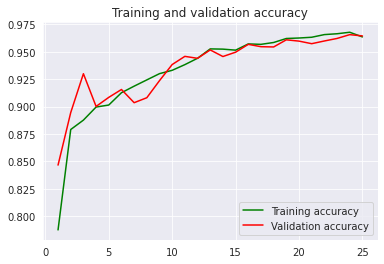

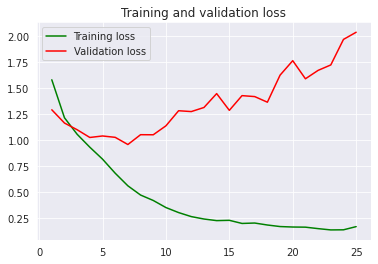

In [38]:
# Plot results
import matplotlib.pyplot as plt

accuracy = his.history['accuracy']
val_acc = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']

epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
y_pred = nlp_model.predict(test_tokens)
y_pred = np.argmax(y_pred, axis=-1)

In [40]:
y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
nlp_model.evaluate(test_tokens, y_test)

(509, 112) (509, 112)
16/16 [==============================] - 1s 34ms/step - loss: 0.2163 - accuracy: 0.9441


[0.21628043055534363, 0.9440955519676208]

In [41]:
y_test_list = []
y_pred_list = []
for row in range(0, y_test.shape[0]):
  y_pred_list = np.concatenate((y_pred_list, y_pred[row]), axis=0)
  y_test_list = np.concatenate((y_test_list, y_test[row]), axis=0)
  # y_test_list = y_test_list + y_test[row]

In [42]:
data_prediction = pd.DataFrame({'actual_class': y_test_list, 'predicted_class': y_pred_list})
data_prediction['actual_class'] = data_prediction['actual_class'].map(idx2tag)
data_prediction['predicted_class'] = data_prediction['predicted_class'].map(idx2tag)

In [43]:
data_prediction

actual_class predicted_class
0            B-LOC           B-ORG
1            B-LOC           B-ORG
2            B-ORG           B-ORG
3            B-PER           B-PER
4            B-LOC           B-ORG
...            ...             ...
57003            O               O
57004            O               O
57005            O               O
57006            O               O
57007            O               O

[57008 rows x 2 columns]

In [44]:
confusion_matrix = pd.crosstab(data_prediction['predicted_class'], data_prediction['actual_class'])
confusion_matrix

actual_class     B-LOC  B-ORG  B-PER  I-LOC  I-ORG  I-PER      O
predicted_class                                                 
B-LOC            14283    315    169    248    158     41    231
B-ORG              705    323     40     31      9      3     17
B-PER              192     15    106      6      6      2      0
I-LOC              442     56      9    290     16      2      9
I-ORG               86     14      2      3    211      0      2
I-PER              232     12      6      9     11    111     56
O                   28      1      0      3      0      0  38497

In [45]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(data_prediction['actual_class'], data_prediction['predicted_class'], output_dict=True)).T

precision    recall  f1-score       support
B-LOC          0.924765  0.894476  0.909369  15968.000000
B-ORG          0.286348  0.438859  0.346567    736.000000
B-PER          0.324159  0.319277  0.321700    332.000000
I-LOC          0.351942  0.491525  0.410184    590.000000
I-ORG          0.663522  0.513382  0.578875    411.000000
I-PER          0.254005  0.698113  0.372483    159.000000
O              0.999169  0.991884  0.995513  38812.000000
accuracy       0.944096  0.944096  0.944096      0.944096
macro avg      0.543416  0.621074  0.562099  57008.000000
weighted avg   0.953998  0.944096  0.948283  57008.000000